# Clean + Create the Tracking Dataset for the Project
First, we will clean and reduce the tracking data so it's in a more readily usable format.

### Reading In
**Note** We have reduced the week tracking datasets to the first 100 records due to file size constraints for submission.

In [1]:
# library imports
import pandas as pd
import re
import matplotlib.pyplot as plt

# import football field function
from functions import create_football_field

# load in player data
players = pd.read_csv("./data/players.csv")[
    ["nflId", "officialPosition", "displayName"]
]

# import plays
pass_plays = pd.read_csv("./data/plays.csv")

# Read the first week of tracking data
tracking_df = pd.read_csv("./data/week1.csv")

# loop through weeks 2-8 and append to the dataframe
for i in range(2, 9):
    tracking_df = pd.concat([tracking_df, pd.read_csv("./data/week" + str(i) + ".csv")])

### Cap Anomalies and Drop Duplicates

In [2]:
# Cap anomalies in tracking data
tracking_df.loc[tracking_df["x"] < 0, "x"] = 0
tracking_df.loc[tracking_df["x"] > 120, "x"] = 120
tracking_df.loc[tracking_df["y"] < 0, "y"] = 0
tracking_df.loc[tracking_df["y"] > 53.3, "y"] = 53.3

# take distinct gameid, playid, frameid, nflid
tracking_df = tracking_df.drop_duplicates(
    subset=["gameId", "playId", "frameId", "nflId"]
).dropna(subset=["x", "y"])

# join players
tracking_df = tracking_df.merge(players, on=['nflId'])

## Derive QB Directions
Now we will estimate if a QB ended up moving to their right or left after the snap.

In [3]:
# filter for QBs
qb_df = tracking_df[tracking_df["officialPosition"] == "QB"]

# get indicators of pass forwards
forward_passes_inds = (
    qb_df[qb_df["event"] == "pass_forward"][[
        "gameId", "playId", "y", "nflId"]]
    .rename(columns={"y": "y_pass_forward"})
    .drop_duplicates(subset=["gameId", "playId", "nflId"])
)

# get indicators of ball snaps
ball_snap_inds = (
    qb_df[qb_df["event"] == "ball_snap"][[
        "gameId", "playId", "y", "nflId"]]
    .rename(columns={"y": "y_ball_snap"})
    .drop_duplicates(subset=["gameId", "playId", "nflId"])
)

# join back to qb_tracking_df
qb_movement_df = qb_df.merge(
    forward_passes_inds, 
    on=["gameId", "playId", "nflId"], 
    how="left"
).merge(
    ball_snap_inds, 
    on=["gameId", "playId", "nflId"], 
    how="left"
)

# filter for non-null values
qb_movement_df = qb_movement_df[
    ~qb_movement_df["y_pass_forward"].isnull()
    & ~qb_movement_df["y_ball_snap"].isnull()
]

# if playDirection is left and y_ball_snap > y_pass_forward, qb_direction = "left"
qb_movement_df.loc[
    (qb_movement_df["playDirection"] == "left")
    & (qb_movement_df["y_ball_snap"] > qb_movement_df["y_pass_forward"]),
    "qb_direction",
] = "left"

# if playDirection is left and y_ball_snap < y_pass_forward, qb_direction = "right"
qb_movement_df.loc[
    (qb_movement_df["playDirection"] == "left")
    & (qb_movement_df["y_ball_snap"] < qb_movement_df["y_pass_forward"]),
    "qb_direction",
] = "right"

# if playDirection is right and y_ball_snap > y_pass_forward, qb_direction = "right"
qb_movement_df.loc[
    (qb_movement_df["playDirection"] == "right")
    & (qb_movement_df["y_ball_snap"] > qb_movement_df["y_pass_forward"]),
    "qb_direction",
] = "right"

# if playDirection is right and y_ball_snap < y_pass_forward, qb_direction = "left"
qb_movement_df.loc[
    (qb_movement_df["playDirection"] == "right")
    & (qb_movement_df["y_ball_snap"] < qb_movement_df["y_pass_forward"]),
    "qb_direction",
] = "left"

# take distinct gameId, playId, qb_direction
qb_movement_df = qb_movement_df[
    ["gameId", "playId", "qb_direction"]
].drop_duplicates()

# join to tracking_df
tracking_df = tracking_df.merge(
    qb_movement_df, on=["gameId", "playId"], how="left"
)

## Derive Receivers
We wil now works backwards from the names in the play-by-play data to determine who the intended receiver was on a given play.

In [4]:
# filter plays for pass plays
pass_plays = pass_plays[pass_plays["passResult"].isin(["C", "I", "IN"])]

# derive WR name from playDescription text
# regex is "to {FirstInitial}.{LastName}"
# if not found, set to None
pass_plays["wr_name"] = pass_plays["playDescription"].apply(
    lambda x: re.search(r"to\s[A-Z]\.[A-Za-z]+", x)
)
pass_plays["wr_name"] = pass_plays["wr_name"].apply(
    lambda x: x.group(0) if x else None
)

# filter out nan
pass_plays = pass_plays[pass_plays["wr_name"].notnull()]

# remove 'to ' from wr_name
pass_plays["wr_name"] = pass_plays["wr_name"].str.split("to ").str[1]

### Join to tracking

In [5]:
forward_df = tracking_df[tracking_df["event"] == "pass_forward"]

# take distinct events
forward_df = forward_df.drop_duplicates(subset=["gameId", "playId", "nflId"])

# create firstInitial.LastName column
forward_df.loc[:, "wr_name"] = (
    forward_df["displayName"].str.split(" ").str[0].str[0]
    + "."
    + forward_df["displayName"].str.split(" ").str[1]
)

# join tracking data with pass plays
rec_df = forward_df.merge(
    pass_plays[["gameId", "playId", "wr_name", "passResult"]],
    on=["gameId", "playId", "wr_name"],
    how="left",
    indicator=True,
)

# filter for plays we have a match on
rec_df = rec_df[rec_df["_merge"] == "both"][
    ["gameId", "playId", "x", "y", "nflId", "passResult"]
].rename(columns={"x": "rec_x", "y": "rec_y", "nflId": "rec_nflId"})

# join receiver data with tracking data
rec_inds = forward_df.merge(rec_df, on=["gameId", "playId"], how="left").drop(
    "wr_name", axis=1
)

# filter out nan rec_nfId
rec_inds = rec_inds[rec_inds["rec_nflId"].notnull()].drop_duplicates(
    subset=["gameId", "playId", "nflId"]
).drop_duplicates(
    subset=["gameId", "playId"]
)

# join to tracking data
tracking_df = tracking_df.merge(
    rec_inds[["gameId", "playId", "rec_nflId", "passResult" , "rec_x", "rec_y"]],
    on=["gameId", "playId"],
    how="left",
)

## Example Plot of QB moving to left

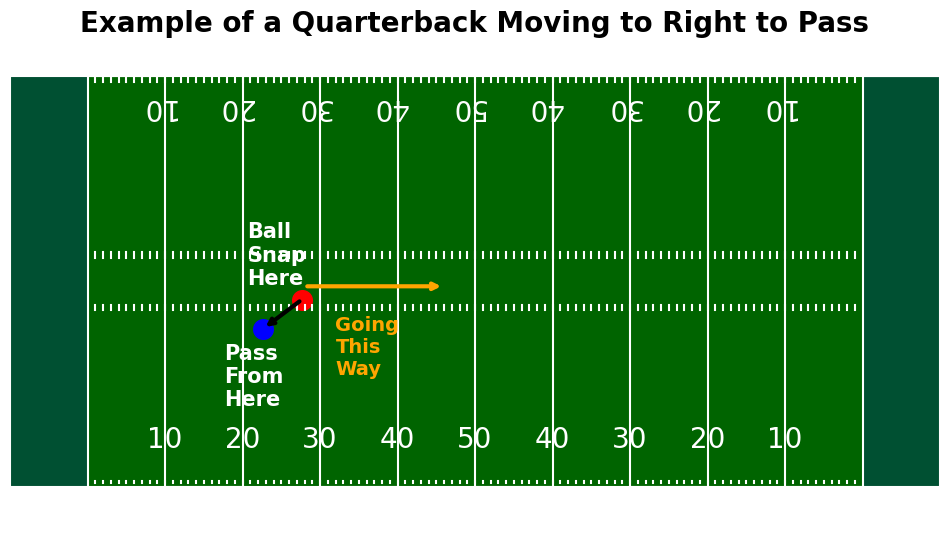

In [11]:
# example play
plot_df = tracking_df[
    (tracking_df["gameId"] == 2021090900) & 
    (tracking_df["playId"] == 97) &
    (tracking_df['officialPosition'] == 'QB') &
    (tracking_df['event'].isin(['pass_forward', 'ball_snap']))
][['gameId', 'playId', 'y', 'x', 'event']]

# plot field
create_football_field()

# add red dot for snap
plt.scatter(
    plot_df[plot_df["event"] == "ball_snap"]["x"],
    plot_df[plot_df["event"] == "ball_snap"]["y"],
    c="red",
    s=200,
)

# add label next to snap
plt.text(
    plot_df[plot_df["event"] == "ball_snap"]["x"] - 7,
    plot_df[plot_df["event"] == "ball_snap"]["y"] + 2,
    "Ball\nSnap\nHere",
    fontsize=15,
    color = 'white',
    fontweight='bold'
)

# add blue dot for pass forward
plt.scatter(
    plot_df[plot_df["event"] == "pass_forward"]["x"],
    plot_df[plot_df["event"] == "pass_forward"]["y"],
    c="blue",
    s=200,
)

# add label next to pass forward
plt.text(
    plot_df[plot_df["event"] == "pass_forward"]["x"] - 5,
    plot_df[plot_df["event"] == "pass_forward"]["y"] - 10,
    "Pass\nFrom\nHere",
    fontsize=15,
    color = 'white',
    fontweight='bold'
)

# draw vertical arrow from snap to pass forward
plt.annotate(
    "",
    xy=(
        plot_df[plot_df["event"] == "pass_forward"]["x"].values[0],
        plot_df[plot_df["event"] == "pass_forward"]["y"].values[0],
    ),
    xytext=(
        plot_df[plot_df["event"] == "ball_snap"]["x"].values[0],
        plot_df[plot_df["event"] == "ball_snap"]["y"].values[0],
    ),
    arrowprops=dict(arrowstyle="->", color="black", lw=3),
)

# add title 
plt.title("Example of a Quarterback Moving to Right to Pass", fontsize=20, fontweight='bold', pad = -5)

# add arrow left denoting direction
plt.annotate(
    "",
    xy=(38, 26),
    xytext=(56, 26),
    arrowprops=dict(arrowstyle="<-", color="orange", lw=3),
)

# add text below arrow
plt.text(
    42,
    14.5,
    "Going\nThis\nWay",
    fontsize=14,
    color = 'orange',
    fontweight='bold'
)

# save
plt.savefig(
    "figures/example_qb_movement.png", 
    dpi=400, 
    bbox_inches="tight"
)

## Final Manipulations
Now we will filter the tracking data to pass forward or pass arrived events, and players with certain positions to allow the file to be smaller and uploadable to GitHub.

In [7]:
# filter tracking data to events pass_forward and pass_arrived
# and position one of QB, WR, TE, RB, FB
final_df = tracking_df[
    (tracking_df["event"].isin(["pass_forward", "pass_arrived"])) & (
        tracking_df["officialPosition"].isin(["QB", "WR", "TE", "RB", "FB"]))
]


In [8]:
# write to csv
final_df.to_csv("./data/tracking_data.csv", index=False)